# Grocery Sales Database
Christabelle Gontani, Madeline Agusalim, Jennifer Meisha, Kaitlyn Huang

1. Customer Segmentation via Clustering Analysis
2. Customer’s Next Purchase Category
3. Customer Churn Prediction


In [ ]:
import pandas as pd
customers = pd.read_csv('/content/drive/MyDrive/customers.csv')
products = pd.read_csv('/content/drive/MyDrive/products.csv')
categories = pd.read_csv('/content/drive/MyDrive/categories.csv')
countries = pd.read_csv('/content/drive/MyDrive/countries.csv')
cities = pd.read_csv('/content/drive/MyDrive/cities.csv')
sales = pd.read_csv('/content/drive/MyDrive/sales.csv')

In [ ]:
customers.head()

In [ ]:
products.head()

In [ ]:
categories.head()

In [ ]:
countries.head()

In [ ]:
cities.head()

In [ ]:
sales.head()

In [ ]:
def quick_eda(df, name):
    print(f"TABLE : {name}")
    print(df.shape)
    print(df.dtypes)
    print(df.isna().sum())
    print(df.head())
    print("\n")

quick_eda(customers, "Customers")
quick_eda(products, "Products")
quick_eda(categories, "Categories")
quick_eda(sales, "Sales")
quick_eda(countries, "Countries")
quick_eda(cities, "Cities")


In [ ]:
# convert into string
sales['CustomerID'] = sales['CustomerID'].astype(str)
sales['ProductID'] = sales['ProductID'].astype(str)
customers['CustomerID'] = customers['CustomerID'].astype(str)
products['ProductID'] = products['ProductID'].astype(str)


In [ ]:
# Sales Data
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')
sales = sales.dropna(subset=['SalesDate']) # too many missing values

# Merge sales w products
sales = sales.merge(products[['ProductID', 'Price', 'CategoryID']], on='ProductID', how='left')
sales['TotalPrice'] = sales['Quantity'] * sales['Price'] # total price
sales.head()


In [ ]:
# merge dataset
df = sales.merge(customers, on='CustomerID', how='left') \
          .merge(cities, on='CityID', how='left') \
          .merge(countries, on='CountryID', how='left') \
          .merge(categories[['CategoryID','CategoryName']], on='CategoryID', how='left')

print(df.head())
df.isna().sum()


In [ ]:
df = df.drop(columns=['FirstName','LastName','MiddleInitial','Address'])

In [ ]:
df['CountryCode'].unique()
df['CountryID'].unique() # only has American cities

In [ ]:
list(df.columns)

In [ ]:
# drop country, cities
df_clean = df.copy()
df_clean = df_clean.drop(columns=['CountryID','CountryCode', 'CountryName', 'CityID', 'CityName', 'Zipcode'])
df_clean.head()

In [ ]:
import matplotlib.pyplot as plt

df_clean.groupby('CategoryName')['TotalPrice'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top Categories by Revenue")
plt.show()


In [ ]:
# Monthly count
monthly = sales.set_index('SalesDate').resample('ME')['SalesID'].count()

plt.figure(figsize=(12,5))
monthly.plot(color="#1f77b4", linewidth=2)
plt.title("Purchases Over Time (Monthly)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1 - Prep Data for Customer Clustering
df_model = df_clean.copy()
df_model.head()

In [ ]:
# Step 2 - Feature Engineering : Monetary Features

# Total Spend
total_spend = df_model.groupby('CustomerID')['TotalPrice'].sum().rename("TotalSpend")

# Number of Transactions
num_tx = df_model.groupby('CustomerID')['SalesID'].nunique().rename("NumTransactions")

# Avg Order Value
avg_order_value = (total_spend / num_tx).rename("AvgOrderValue")

# Spend per Category (Pivot Table)
cat_spend = df_model.pivot_table(
    index='CustomerID',
    columns='CategoryName',
    values='TotalPrice',
    aggfunc='sum',
    fill_value=0
)

# Spend concentration (% of spend in top categories)
top1 = cat_spend.max(axis=1) / cat_spend.sum(axis=1)
top2 = cat_spend.apply(lambda row: row.nlargest(2).sum(), axis=1) / cat_spend.sum(axis=1)

top1 = top1.rename("SpendTop1")
top2 = top2.rename("SpendTop2")

print(top1.shape, top2.shape)
cat_spend.head()



In [ ]:
# Step 3 - Feature Engineering : Frequency & Recency
import numpy as np

# Frequency = number of transactions
frequency = num_tx.rename("Frequency")

# Recency = days since last purchase
max_date = df_clean['SalesDate'].max()
recency = (max_date - df_clean.groupby('CustomerID')['SalesDate'].max()).dt.days.rename("RecencyDays")

# Avg Time Between Purchases
purchase_dates = df_clean.groupby('CustomerID')['SalesDate'].agg(list)

avg_time_between = purchase_dates.apply(
    lambda dates: np.mean(np.diff(sorted(dates))).days if len(dates) > 1 else np.nan
).rename("AvgTimeBetweenPurchases")

In [ ]:
# Step 4 - Feature Engineering :  Basket Composition

# Average basket size
avg_basket_size = df_clean.groupby('CustomerID')['Quantity'].mean().rename("AvgBasketSize")

# Category variety (# unique categories purchased)
cat_variety = df_clean.groupby('CustomerID')['CategoryName'].nunique().rename("CategoryVariety")

# Category mix (% of spend per category)
cat_mix = cat_spend.div(cat_spend.sum(axis=1), axis=0).add_prefix("CatMix_")

In [ ]:
# Step 5 - Build Customer-Level Feature Table

customer_features = (
    total_spend
    .to_frame()
    .join(avg_order_value)
    .join(frequency)
    .join(recency)
    .join(avg_time_between)
    .join(avg_basket_size)
    .join(cat_variety)
    .join(cat_spend.add_prefix("Spend_"))
    .join(cat_mix)
    .join(top1)
    .join(top2)
)

customer_features.head()

In [ ]:
# Step 6 -  Scale Features for Clustering
from sklearn.preprocessing import StandardScaler

# Replace NaN or infinite values across whole table (safety check)
customer_features = customer_features.replace([np.inf, -np.inf], np.nan)
customer_features = customer_features.fillna(0)

# Scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

scaled_features[:5]


In [ ]:
# Step 7 - Clustering (KMeans, Elbow, Silhouette)

# elbow
from sklearn.cluster import KMeans

inertia = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    print(f"K={k}, Silhouette={score:.4f}")


K=2, Silhouette=0.4037
K=3, Silhouette=0.4067
K=4, Silhouette=0.3553
K=5, Silhouette=0.3488
K=6, Silhouette=0.3598


In [ ]:
# Step 8 - K Means

best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans.fit_predict(scaled_features)

customer_features.head()


,TotalSpend,AvgOrderValue,Frequency,RecencyDays,AvgTimeBetweenPurchases,AvgBasketSize,CategoryVariety,Spend_Beverages,Spend_Cereals,Spend_Confections,...,CatMix_Grain,CatMix_Meat,CatMix_Poultry,CatMix_Produce,CatMix_Seafood,CatMix_Shell fish,CatMix_Snails,SpendTop1,SpendTop2,Cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,
1,3246.6104,51.533498,63,3,1,1.0,11,214.7525,409.0242,186.5363,...,0.170668,0.081740,0.100049,0.148174,0.042811,0.095427,0.044736,0.170668,0.318843,2
10,3042.4604,55.317462,55,1,2,1.0,11,447.9441,354.8458,482.7720,...,0.041164,0.060334,0.108320,0.047807,0.056431,0.075960,0.117542,0.158678,0.305909,2
100,3159.8992,55.436828,57,4,2,1.0,11,439.2697,561.1025,230.5718,...,0.100729,0.062086,0.088952,0.081586,0.048672,0.090520,0.066355,0.177570,0.316584,2
1000,3968.2580,55.114694,72,0,1,1.0,11,200.2362,237.8124,439.4911,...,0.151909,0.054321,0.061673,0.115806,0.170499,0.054870,0.063031,0.170499,0.322408,2
10000,8702.7534,150.047472,58,0,2,3.0,11,430.3980,1088.1045,1507.8978,...,0.086595,0.103142,0.079253,0.098534,0.061469,0.074207,0.105658,0.173267,0.298297,2


In [ ]:
# Step 9 - Customer Personas
customer_features["Cluster"].value_counts() # cluster sizes


Cluster
2    32860
0    25703
3    24721
1    15475
Name: count, dtype: int64

In [ ]:
cluster_summary = customer_features.groupby("Cluster").mean()
cluster_summary


,TotalSpend,AvgOrderValue,Frequency,RecencyDays,AvgTimeBetweenPurchases,AvgBasketSize,CategoryVariety,Spend_Beverages,Spend_Cereals,Spend_Confections,...,CatMix_Dairy,CatMix_Grain,CatMix_Meat,CatMix_Poultry,CatMix_Produce,CatMix_Seafood,CatMix_Shell fish,CatMix_Snails,SpendTop1,SpendTop2
Cluster,,,,,,,,,,,,,,,,,,,,,
0,44422.040111,659.355833,68.188850,1.402755,1.278567,13.056430,10.983893,3919.891631,4316.077597,5013.742717,...,0.084561,0.079400,0.106555,0.100300,0.088058,0.080374,0.073898,0.088764,0.158440,0.294101
1,53618.419531,848.273647,63.763619,1.588821,1.521422,16.815873,10.886010,4093.236282,5381.905395,8865.763660,...,0.075874,0.063090,0.128947,0.104421,0.078372,0.068170,0.059225,0.079729,0.205665,0.358278
2,15899.688042,240.951898,66.779702,1.489501,1.352222,4.784358,10.956208,1345.655988,1578.120607,2072.059442,...,0.081516,0.074088,0.115001,0.101892,0.084787,0.075451,0.068797,0.085435,0.174195,0.315975
3,77979.103262,1102.716848,71.065814,1.353667,1.152219,21.473164,10.981675,6707.539839,7692.643190,9474.140985,...,0.082886,0.077387,0.110550,0.100930,0.086497,0.077890,0.071175,0.087098,0.164537,0.302268


In [ ]:
cat_cols = [c for c in customer_features.columns if c.startswith("Spend_")]
customer_features.groupby("Cluster")[cat_cols].mean()


,Spend_Beverages,Spend_Cereals,Spend_Confections,Spend_Dairy,Spend_Grain,Spend_Meat,Spend_Poultry,Spend_Produce,Spend_Seafood,Spend_Shell fish,Spend_Snails
Cluster,,,,,,,,,,,
0,3919.891631,4316.077597,5013.742717,3752.180141,3531.876243,4736.415655,4458.234353,3907.002830,3566.685409,3279.241517,3940.692019
1,4093.236282,5381.905395,8865.763660,4066.024823,3384.185370,6920.882688,5603.596263,4198.725233,3658.112947,3168.790974,4277.195897
2,1345.655988,1578.120607,2072.059442,1294.418735,1170.118588,1837.373293,1624.521466,1345.361304,1192.402697,1084.811277,1354.844647
3,6707.539839,7692.643190,9474.140985,6456.296740,6023.787266,8647.966419,7871.249585,6724.216408,6060.511287,5535.276221,6785.475322


In [ ]:
mix_cols = [c for c in customer_features.columns if c.startswith("CatMix_")]
customer_features.groupby("Cluster")[mix_cols].mean()


,CatMix_Beverages,CatMix_Cereals,CatMix_Confections,CatMix_Dairy,CatMix_Grain,CatMix_Meat,CatMix_Poultry,CatMix_Produce,CatMix_Seafood,CatMix_Shell fish,CatMix_Snails
Cluster,,,,,,,,,,,
0,0.088148,0.097131,0.112812,0.084561,0.079400,0.106555,0.100300,0.088058,0.080374,0.073898,0.088764
1,0.076464,0.100353,0.165355,0.075874,0.063090,0.128947,0.104421,0.078372,0.068170,0.059225,0.079729
2,0.084921,0.098785,0.129327,0.081516,0.074088,0.115001,0.101892,0.084787,0.075451,0.068797,0.085435
3,0.086155,0.098624,0.120809,0.082886,0.077387,0.110550,0.100930,0.086497,0.077890,0.071175,0.087098


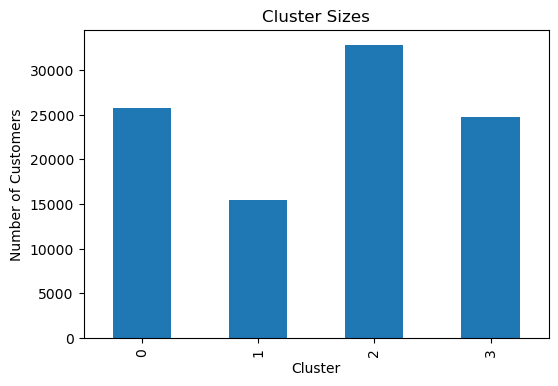

In [ ]:
customer_features["Cluster"].value_counts().sort_index().plot(kind='bar', figsize=(6,4))
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


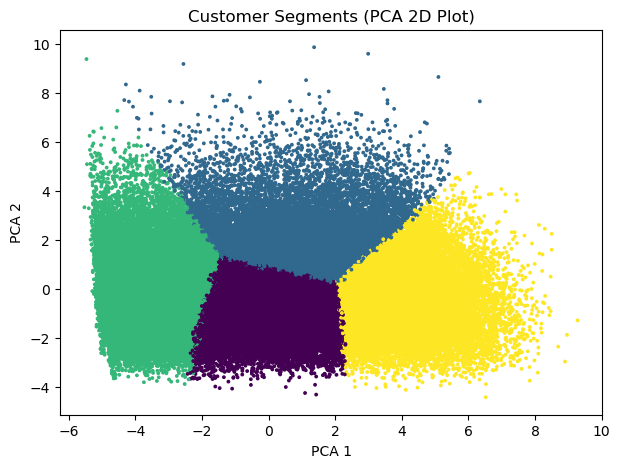

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_comp = pca.fit_transform(scaled_features)

plt.figure(figsize=(7,5))
plt.scatter(pca_comp[:,0], pca_comp[:,1], c=customer_features["Cluster"], cmap='viridis', s=3)
plt.title("Customer Segments (PCA 2D Plot)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


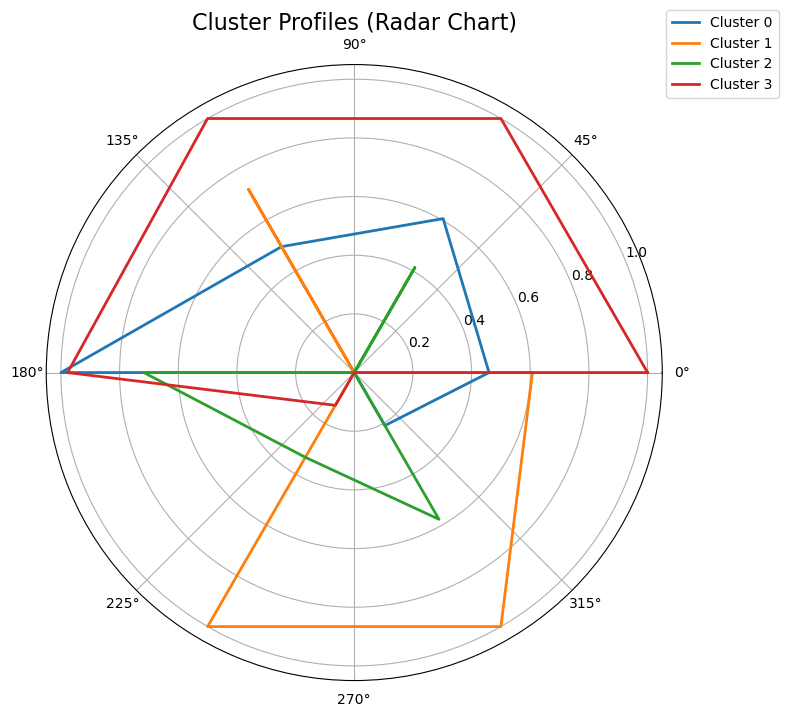

In [ ]:
key_features = ["TotalSpend", "Frequency", "AvgBasketSize",
                "CategoryVariety", "SpendTop1", "RecencyDays"]

cluster_means = customer_features.groupby("Cluster")[key_features].mean()

# Normalize 0-1 for radar plot
cluster_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Radar chart
labels = cluster_normalized.columns
num_vars = len(labels)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # loop back

plt.figure(figsize=(8,8))
for i, row in cluster_normalized.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {i}", linewidth=2)

plt.title("Cluster Profiles (Radar Chart)", fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


### Customer Personas from Clustering Analysis

Cluster 0 — Steady General Shoppers
 Medium spend ($44,400) | Average Order ($650) | Balanced basket (13 items)
 → steady frequent customers with balanced purchasing pattern

Cluster 1 — Focused High-Value Shoppers
 High spend ($53,600) | Average Order ($848) | Higher basket (16 items)
 → lowest frequency, highest category concentration (Top1 = 0.206)
so slightly more category-focused
 → good for targeted category promos

Cluster 2 — Light / Price-Sensitive Shoppers
 Lowest spend ($15,900) | Average Order ($240) | Smaller basket (4 items)
 → occasional visitors, buy essentials only with low spend across all categories
 → opportunity for basket-growth strategies

Cluster 3 — Premium Power Shoppers
 Highest spend ($77,900) | Average Order ($1102) | Largest baskets (21 items)
 → loyal, high-value customers across all categories (highest RFM)

### Prediction Task 2: Predict whether a customer will churn



#### Determine the Churn Definition
To create a meaningful churn label, we tested multiple RecencyDays thresholds (7, 10, 14, 20, 25, 30).  
Our goal was to find a cutoff that:

- Produces a realistic churn rate  
- Avoids extreme class imbalance  
- Preserves enough positive (churn) examples for modeling  

Based on the results, **Recency > 7 days** gives a churn rate of ~1–2%, which is balanced enough for training a predictive model in this dataset.


In [ ]:
for cutoff in [7, 10, 14, 20, 25, 30]:
    pct = (customer_features['RecencyDays'] > cutoff).mean()
    print(f"Cutoff {cutoff} days , churn rate = {pct:.3f}")

We define a customer as *churned* if they have not made a purchase in the last **7 days**.  
This produces a binary churn column we can use for supervised learning.

In [ ]:
customer_features['Churn'] = (customer_features['RecencyDays'] > 7).astype(int)
customer_features['Churn'].value_counts()

Before modeling, we analyze churn across the four customer clusters we created earlier.  
This reveals whether certain segments are more likely to churn and helps us interpret the final results.

In [ ]:
customer_features.groupby('Cluster')['Churn'].mean()


In [ ]:
customer_features.head()

#### Train Global Churn Models

We train three different classification models on *all customers*:

- Logistic Regression  
- Random Forest  
- Gradient Boosting  

We remove RecencyDays before training to avoid data leakage, then evaluate all models using an 80/20 train–test split with stratification.

This global model represents our baseline approach.

For churn model evaluation we will prioritize:
* recall since missing a churner is costly
* precision
* f1 score
* roc-auc (the model's ability to separate churners vs non-churners acorss all threshold)

We won't be using accuracy for churn since a model predicting that "everyone stays" could reach a high accuracy but detect no churners. Accuracy hides the model's ability to capture the minority class.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Remove leakage
X = customer_features.drop(['Churn', 'RecencyDays'], axis=1)
y = customer_features['Churn']

# Global train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
#Baseline Model
majority_class = y_train.mode()[0]

baseline_acc = (y_test == majority_class).mean()
print(f'Baseline Test Accuracy: {baseline_acc:.4f}')

y_pred_baseline = [majority_class] * len(y_test)

cm = confusion_matrix(y_test, y_pred_baseline)
tn, fp, fn, tp = cm.ravel()

baseline_TPR = tp / (tp + fn) if (tp + fn) > 0 else 0

baseline_PRE = tp / (tp + fp) if (tp + fp) > 0 else 0

baseline_f1 = f1_score(y_test, y_pred_baseline)

y_pred_proba_baseline = np.zeros(len(y_test))
baseline_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print(f"Baseline TPR: {baseline_TPR:.4f}")
print(f"Baseline Precision: {baseline_PRE:.4f}")
print("F1 Score:", baseline_f1)
print(f'Baseline Test AUC: {baseline_auc:.4f}')


In [ ]:
#logistic regression

# do not overwrite the original X_train/X_test
X_train_global = scaler.fit_transform(X_train)
X_test_global = scaler.transform(X_test)

y_train_global = y_train.copy()
y_test_global  = y_test.copy()

for cluster_id in sorted(customer_features['Cluster'].unique()):

    print(f"\n--- Cluster {cluster_id} ---")

    # Mask FROM ORIGINAL GLOBAL SPLIT
    train_mask = (customer_features.loc[y_train_global.index, 'Cluster'] == cluster_id)
    test_mask  = (customer_features.loc[y_test_global.index,  'Cluster'] == cluster_id)

    X_train_c = X_train_global[train_mask]
    y_train_c = y_train_global[train_mask]

    X_test_c  = X_test_global[test_mask]
    y_test_c  = y_test_global[test_mask]

    # Safety checks
    if y_train_c.sum() < 3:
        print("Not enough churn samples to train.")
        continue

    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train_c, y_train_c)

    y_pred_c = model.predict(X_test_c)
    y_proba_c = model.predict_proba(X_test_c)[:, 1]

    cm = confusion_matrix(y_test_c, y_pred_c)
    tn, fp, fn, tp = cm.ravel()

    log_TPR = tp / (tp + fn) if (tp + fn) > 0 else 0

    log_PRE = tp / (tp + fp) if (tp + fp) > 0 else 0

    log_f1 = f1_score(y_test_c, y_pred_c)

    log_auc = roc_auc_score(y_test_c, y_proba_c)

    log_acc = accuracy_score(y_test_c, y_pred_c)
    log_f1  = f1_score(y_test_c, y_pred_c)
    log_auc = roc_auc_score(y_test_c, y_proba_c)

    print(f'Logistic Regression Test Accuracy: {log_acc:.4f}')
    print(f"Logistic Regression TPR: {log_TPR:.4f}")
    print(f"Logistic Regression Precision: {log_PRE:.4f}")
    print("F1 Score:", log_f1)
    print(f'Logistic Regression Test AUC: {log_auc:.4f}')

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': [10, 20, 30, 40, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True]
}

for cluster_id in sorted(customer_features['Cluster'].unique()):

    print(f"\n=== RANDOM FOREST — CLUSTER {cluster_id} ===")

    # Masks from original global split
    train_mask = (customer_features.loc[y_train_global.index, 'Cluster'] == cluster_id)
    test_mask  = (customer_features.loc[y_test_global.index,  'Cluster'] == cluster_id)

    X_train_c = X_train_global[train_mask]
    y_train_c = y_train_global[train_mask]

    X_test_c  = X_test_global[test_mask]
    y_test_c  = y_test_global[test_mask]

    # Skip clusters without churn representation
    if y_train_c.sum() < 5 or y_test_c.sum() < 2:
        print("Not enough churn samples — skipping.")
        continue

    # Random Forest with hyperparameter search
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

    rf_search = RandomizedSearchCV(
        rf_base,
        param_distributions=param_dist,
        n_iter=15,
        cv=3,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    rf_search.fit(X_train_c, y_train_c)

    print("Best params:", rf_search.best_params_)
    print("Best CV AUC:", rf_search.best_score_)

    # Train final model on cluster-specific best params
    rf_final = rf_search.best_estimator_
    rf_final.fit(X_train_c, y_train_c)

    # Predictions
    y_pred_c = rf_final.predict(X_test_c)
    y_proba_c = rf_final.predict_proba(X_test_c)[:, 1]

    cm = confusion_matrix(y_test_c, y_pred_c)
    tn, fp, fn, tp = cm.ravel()

    rf_TPR = tp / (tp + fn) if (tp + fn) > 0 else 0

    rf_PRE = tp / (tp + fp) if (tp + fp) > 0 else 0

    rf_f1 = f1_score(y_test_c, y_pred_c)

    rf_auc = roc_auc_score(y_test_c, y_proba_c)

    rf_acc = accuracy_score(y_test_c, y_pred_c)

    print(f'Random Forest Test Accuracy: {rf_acc:.4f}')
    print(f"Random Forest TPR: {rf_TPR:.4f}")
    print(f"Random Forest Precision: {rf_PRE:.4f}")
    print("F1 Score:", rf_f1)
    print(f'Random Forest Test AUC: {rf_auc:.4f}')


### Prediction Task 3: Predict whether a customer will churn


#### Determine the Churn Definition
To create a meaningful churn label, we tested multiple RecencyDays thresholds (7, 10, 14, 20, 25, 30).  
Our goal was to find a cutoff that:

- Produces a realistic churn rate  
- Avoids extreme class imbalance  
- Preserves enough positive (churn) examples for modeling  

Based on the results, **Recency > 7 days** gives a churn rate of ~1–2%, which is balanced enough for training a predictive model in this dataset.


In [ ]:
for cutoff in [7, 10, 14, 20, 25, 30]:
    pct = (customer_features['RecencyDays'] > cutoff).mean()
    print(f"Cutoff {cutoff} days , churn rate = {pct:.3f}")

We define a customer as *churned* if they have not made a purchase in the last **7 days**.  
This produces a binary churn column we can use for supervised learning.

In [ ]:
customer_features['Churn'] = (customer_features['RecencyDays'] > 7).astype(int)
customer_features['Churn'].value_counts()

Before modeling, we analyze churn across the four customer clusters we created earlier.  
This reveals whether certain segments are more likely to churn and helps us interpret the final results.

In [ ]:
customer_features.groupby('Cluster')['Churn'].mean()

#### Train Global Churn Models



We train three different classification models on *all customers*:

- Logistic Regression  
- Random Forest  
- Gradient Boosting  

We remove RecencyDays before training to avoid data leakage, then evaluate all models using an 80/20 train–test split with stratification.

This global model represents our baseline approach.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Remove leakage
X = customer_features.drop(['Churn', 'RecencyDays'], axis=1)
y = customer_features['Churn']

# Global train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

global_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

global_results = {}

print("\n=== GLOBAL MODELS ===")
for name, model in global_models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    tpr = recall_score(y_test, y_pred)          # TPR = Recall
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)

    global_results[name] = [acc, tpr, fpr, prec, f1, auc]

    print(f"\n{name}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"TPR/Recall: {tpr:.4f}")
    print(f"FPR       : {fpr:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")

#### Train Cluster-Specific Churn Models
We also test a cluster-then-predict approach:

For each customer segment:
1. Select only the test-set customers in that cluster  
2. Train separate churn models (LR, RF, GB)  
3. Evaluate accuracy within the cluster  

This tests whether cluster-specific models outperform the global model, or whether one unified model is sufficient.

In [ ]:
cluster_model_results = {}

print("CLUSTER THEN PREDICT FOR CHURN")

for c in sorted(customer_features['Cluster'].unique()):
    print(f"\nCLUSTER {c}")

    mask = customer_features.index.isin(X_test.index)
    X_test_only = X_test.copy()
    X_test_only['Cluster'] = customer_features.loc[X_test.index, 'Cluster']

    X_c = X_test_only[X_test_only['Cluster'] == c].drop('Cluster', axis=1)
    y_c = y_test[X_test_only['Cluster'] == c]

    if len(X_c) < 50:
        print("Too few samples — skipping.")
        continue

    try:
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
            X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
        )
    except:
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
            X_c, y_c, test_size=0.2, random_state=42
        )

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42)
    }

    cluster_model_results[c] = {}


    for name, model in models.items():
        model.fit(X_train_c, y_train_c)

        y_pred_c = model.predict(X_test_c)
        y_prob_c = model.predict_proba(X_test_c)[:, 1]

        acc = accuracy_score(y_test_c, y_pred_c)
        prec = precision_score(y_test_c, y_pred_c)
        tpr = recall_score(y_test_c, y_pred_c)
        f1 = f1_score(y_test_c, y_pred_c)
        auc = roc_auc_score(y_test_c, y_prob_c)

        tn, fp, fn, tp = confusion_matrix(y_test_c, y_pred_c).ravel()
        fpr = fp / (fp + tn)

        cluster_model_results[c][name] = [acc, tpr, fpr, prec, f1, auc]

        print(f"\n{name}")
        print(f"Accuracy  : {acc:.4f}")
        print(f"TPR/Recall: {tpr:.4f}")
        print(f"FPR       : {fpr:.4f}")
        print(f"Precision : {prec:.4f}")
        print(f"F1-score  : {f1:.4f}")
        print(f"ROC-AUC   : {auc:.4f}")

### **Churn Prediction Conclusion**

Our churn model achieved **~98.5% accuracy**, showing that churn is highly predictable in this dataset.  
Churn rates were low across all segments (1–2%), and the model performed consistently well for every customer cluster.  
Cluster-specific models did **not** improve performance, confirming that a **single global model is sufficient** and generalizes effectively.

While the model provides useful insights, real-world deployment would require a longer time window, richer behavioral data, and a more realistic churn definition.
